In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from argparse import ArgumentParser
import os

from tokenizer import SimpleTokenizer
from dataset import CLSDataset, LMDataset
from utilities import Utilities

from model import Encoder, Decoder

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
block_size = 32
learning_rate = 1e-3
n_embd = 64
n_head = 2
n_layer = 4

eval_interval = 100
max_iters = 500
eval_iters = 200

n_input = 64
n_hidden = 100
n_output = 3
epochs_CLS = 15

In [3]:
def load_texts(file_dir):
    texts = []
    for file_name in os.listdir(file_dir):
        if 'test' in file_name:
            continue
        texts.append(open(os.path.join(file_dir, file_name), 'r', encoding='utf-8').read())
    return texts

In [5]:
def collate_batch(batch):
    data, labels = zip(*batch)
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]
    padded_sequences = F.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)
    return padded_sequences, labels

def compute_classifier_accuracy(classifier, data_loader):
    classifier.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = classifier(X)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
        
        accuracy = (100 * total_correct / total_samples)
        return accuracy

def compute_perplexity(decoderLM, data_loader, eval_iters=100):
    decoderLM.eval()
    losses = []
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        loss = decoderLM(X, Y)
        losses.append(loss.item())
        if len(losses) >= eval_iters:
            break
    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()

    decoderLM.train()
    return perplexity

Loading data and creating tokenizer ...
Vocabulary size:  5755
Sanity Check ...
Input sentence:  It is costly and politically difficult to continue this conflict.
More of you have lost your homes and even more are watching your home values plummet.
Through this remarkable chapter in the history of the United States and Iraq, we have met our responsibility.
Our relations abroad were strained.
You can tell that I'm a lame duck because nobody's following instructions.
And today, as my call for a time frame to remove our troops from Iraq has been echoed by the Iraqi government and even the Bush Administration, even after we learned that Iraq has a $79 billion surplus while we're wallowing in deficits, John McCain stands alone in his stubborn refusal to end a misguided war.
Over the course of these 8 years, I've seen the hopeful faces of young graduates and our newest military officers.
But most of all, congratulations to the Class of 2016!
The pace of change is not subsiding; it is acceler

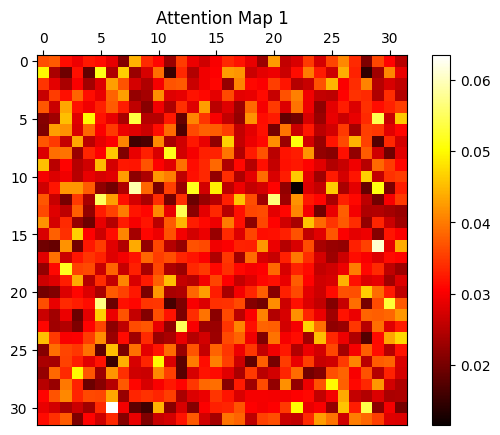

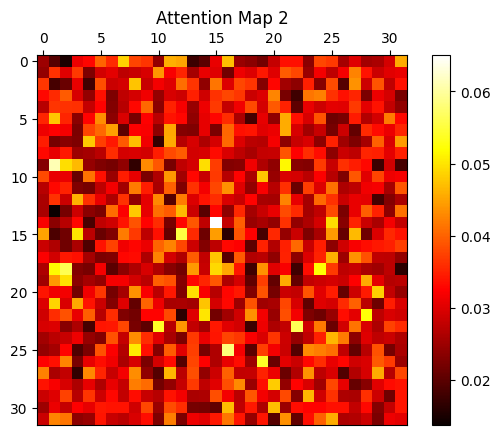

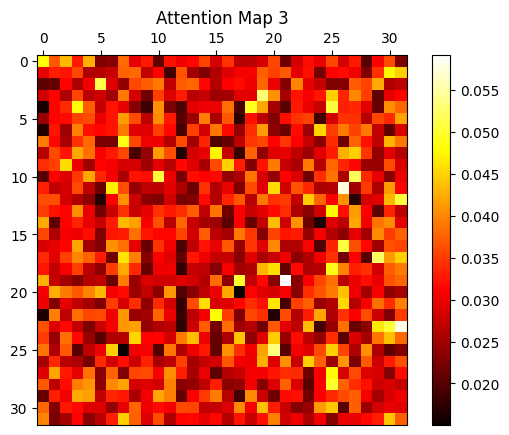

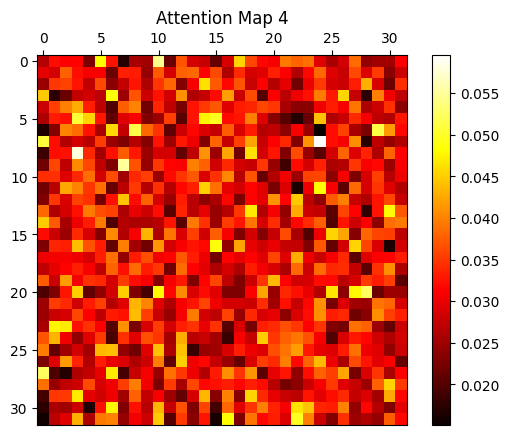

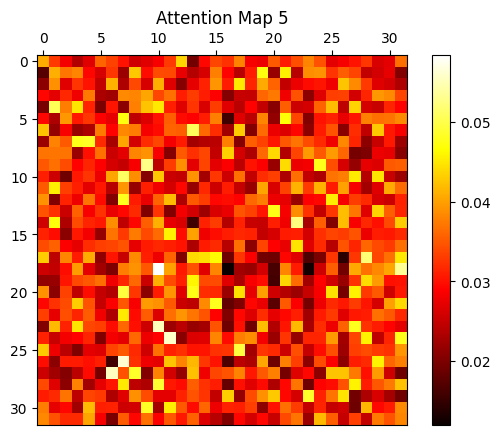

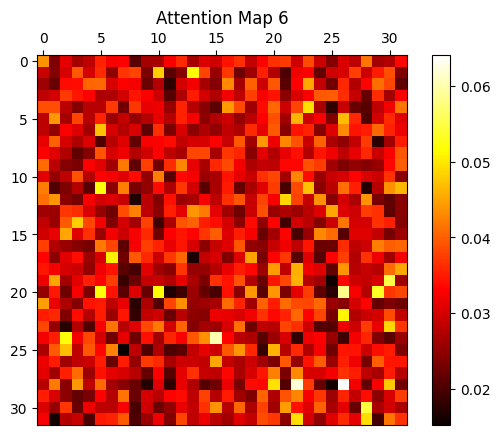

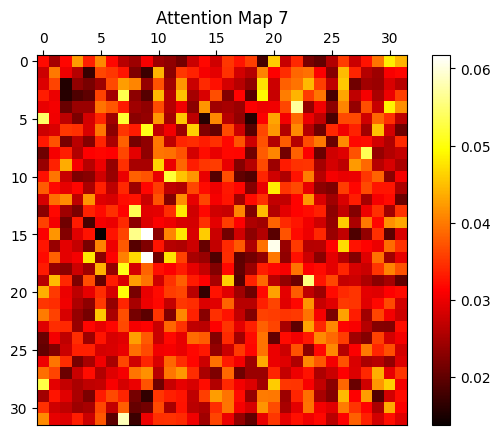

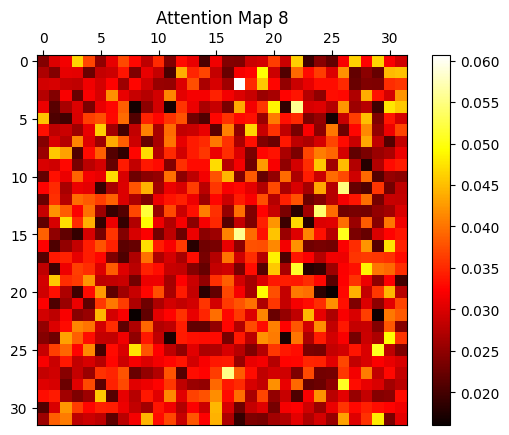

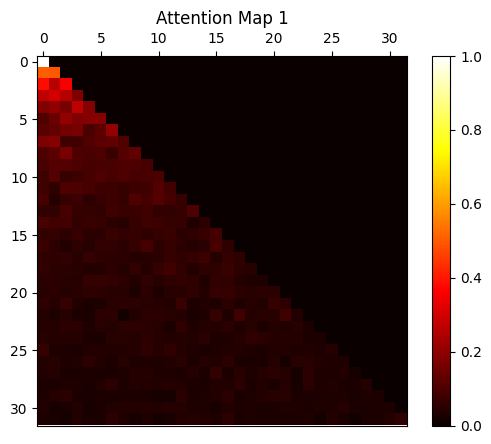

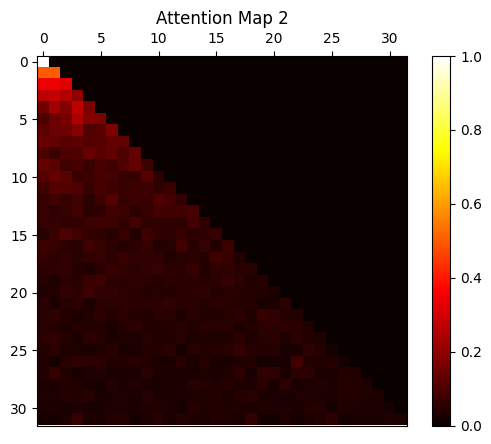

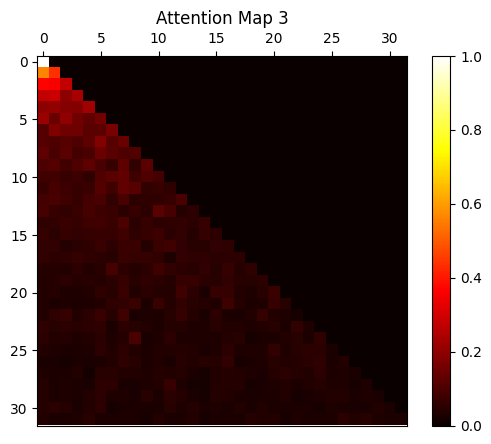

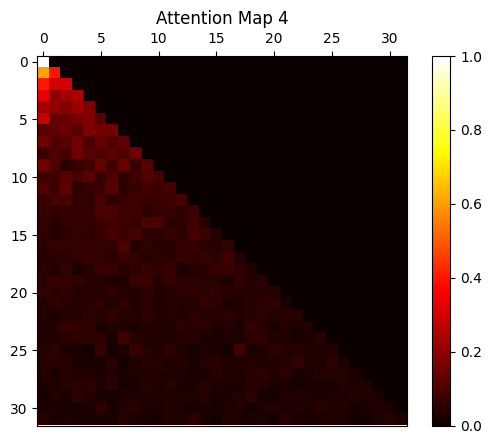

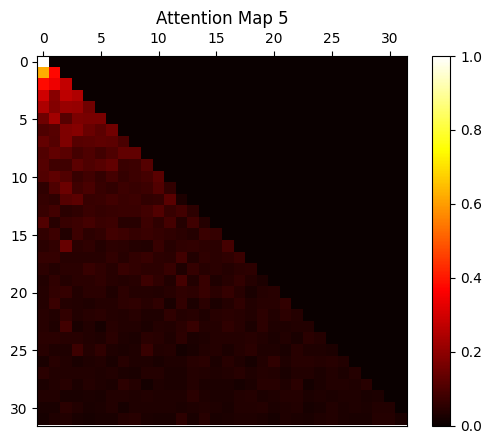

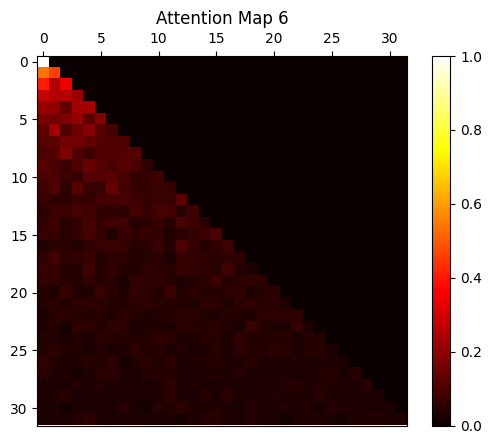

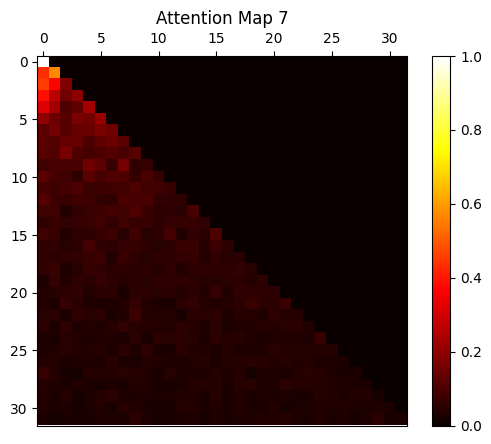

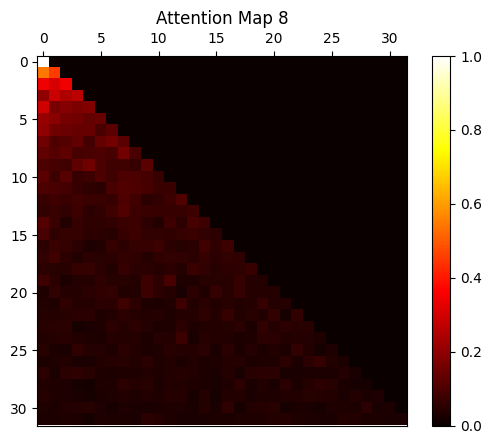

In [6]:
print('Loading data and creating tokenizer ...')
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts))
print("Vocabulary size: ", tokenizer.vocab_size)

print('Sanity Check ...')
encoder = Encoder(vocab_size=tokenizer.vocab_size, d_model=n_embd, hidden_size=n_hidden, block_size=block_size, head_num=n_head, layer_num=n_layer)
decoder = Decoder(vocab_size=tokenizer.vocab_size, d_model=n_embd, hidden_size=n_hidden, block_size=block_size, head_num=n_head, layer_num=n_layer)

utilities = Utilities(tokenizer, encoder)
utilities.sanity_check(texts[0], block_size)
utilities = Utilities(tokenizer, decoder)
utilities.sanity_check(texts[0], block_size)

In [7]:
train_CLS_dataset = CLSDataset(tokenizer, 'speechesdataset/train_CLS.tsv')
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

for epoch in range(epochs_CLS):
    for xb, yb in train_CLS_loader:
        break

In [9]:
xb.shape

torch.Size([16, 32])

In [27]:
train_CLS_dataset = LMDataset(tokenizer, 'speechesdataset/train_LM.txt', block_size=8)
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs_CLS):
    for xb, yb in train_CLS_loader:
        break

In [28]:
xb

('try to ',
 'th care',
 'ed thos',
 ' change',
 ' countr',
 'apply t',
 ' five m',
 "s.\nIt's",
 'omotion',
 "\nIraq's",
 'as.\nLet',
 ' kept m',
 'ining o',
 'd lawle',
 'y of th',
 ' them g')

In [18]:
a.mean(dim=1).shape

torch.Size([4, 768])

In [19]:
texts = load_texts('speechesdataset')

In [20]:
texts

['It is costly and politically difficult to continue this conflict.\nMore of you have lost your homes and even more are watching your home values plummet.\nThrough this remarkable chapter in the history of the United States and Iraq, we have met our responsibility.\nOur relations abroad were strained.\nYou can tell that I\'m a lame duck because nobody\'s following instructions.\nAnd today, as my call for a time frame to remove our troops from Iraq has been echoed by the Iraqi government and even the Bush Administration, even after we learned that Iraq has a $79 billion surplus while we\'re wallowing in deficits, John McCain stands alone in his stubborn refusal to end a misguided war.\nOver the course of these 8 years, I\'ve seen the hopeful faces of young graduates and our newest military officers.\nBut most of all, congratulations to the Class of 2016!\nThe pace of change is not subsiding; it is accelerating.\nAmerica, we cannot turn back.\nBut for those of us fortunate enough to have

In [21]:
s = 'rangdsagdsagf'

In [23]:
list(set(s))

['d', 'n', 'r', 'a', 's', 'f', 'g']